# phoBERT
*Time for run all (GPU) : ~ 8 hours*

<a name="setup-general"></a>
## 1.&nbsp;General Settings
 Install some necessary libraries and download processed data for model training and evaluation

In [ ]:
nepochs = 15
batchsize= 8  #8, 16, 32, 64, 128
learning_rate= 5e-5 # 3e-4, 1e-4, 5e-5, 3e-5
warmup = 0
seed = 0

log_name = '{}_nepochs_{}_batchsize_{}_learning_rate_{}'.format(seed, nepochs, batchsize, learning_rate, warmup)
output = './checkpoints/' + log_name

## 2. Import Libraries

In [ ]:
! pip install transformers
! pip install datasets==2.21.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import Trainer
from transformers import TrainingArguments
from datasets import load_metric
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [ ]:
#Load pre-trained phoBERT for finetuning on our dataset
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 3. Data Preparation
In this section, we will load the dataset from the converted data and prepare for model training

In [ ]:
def tokenize_function(examples):
    tokenized_examples = tokenizer(examples['text'], padding="max_length", truncation=True)

    # Convert label from string to integer
    tokenized_examples['label'] = [int(label_id) for label_id in examples['label_id']]

    return tokenized_examples

In [ ]:
train_dataset = load_dataset("csv", data_files='data/stock_train.csv', split='train')
dev_dataset = load_dataset("csv", data_files='data/stock_train.csv', split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', 'label_id'],
    num_rows: 1516
})

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

## 4.Model training and Evaluation

In [ ]:
! pip install --upgrade accelerate

### Basic settings

In [ ]:
#Hyperparameters
training_args = TrainingArguments(
  output_dir="checkpoint",
  group_by_length=False,
  evaluation_strategy="steps",
  num_train_epochs=nepochs,
  per_device_train_batch_size=batchsize,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  dataloader_num_workers=3, #tune
  learning_rate=learning_rate, #tune
  save_total_limit=15, #tune
  eval_accumulation_steps=2000, #tune
  warmup_ratio=0.1,
  report_to='tensorboard'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, label_id = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=label_id, average='weighted')

<ipython-input-11-0dafbfbb052e>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


### Training

In [ ]:
from transformers import DataCollatorWithPadding

# Assuming you have a tokenizer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=dev_dataset, compute_metrics=compute_metrics, data_collator=data_collator
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Step,Training Loss,Validation Loss,F1
500,0.693100,0.233381,0.931501
1000,0.267800,0.065653,0.983527
1500,0.085300,0.019689,0.996701
2000,0.027300,0.004987,0.998021
2500,0.009600,0.003413,0.998681


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/util

TrainOutput(global_step=2850, training_loss=0.1905970725678561, metrics={'train_runtime': 440.0271, 'train_samples_per_second': 51.679, 'train_steps_per_second': 6.477, 'total_flos': 566645578680888.0, 'train_loss': 0.1905970725678561, 'epoch': 15.0})

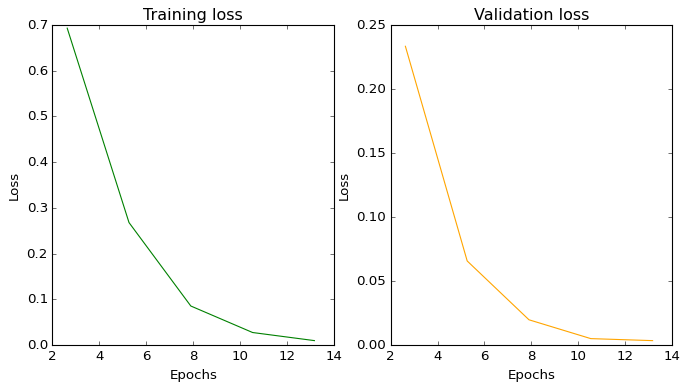

In [ ]:
history = trainer.state.log_history

train_loss = []
val_loss = []
epochs_train = []
epochs_val = []

for entry in history:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append(entry['loss'])
        epochs_train.append(entry['epoch'])
    if 'eval_loss' in entry and 'epoch' in entry:
        val_loss.append(entry['eval_loss'])
        epochs_val.append(entry['epoch'])

plt.figure(figsize=(10, 5), facecolor='white')

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.plot(epochs_train, train_loss, color='green')
plt.gca().set_facecolor('white')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.plot(epochs_val, val_loss, color='orange')
plt.gca().set_facecolor('white')

plt.show()

In [ ]:
model.save_pretrained("output/trained_Bertmodel")

In [ ]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
device = 'cpu'

### Evaluation on test set

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
phoBERTmodel = AutoModelForSequenceClassification.from_pretrained('output/trained_Bertmodel')

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
phoBERTmodel.config.from_pretrained('output/trained_Bertmodel/config.json')

RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "PhobertTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
test_data = pd.read_json('data/stock_test.json')

predictions = []
labels = []

In [ ]:
test_data

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [ ]:
for i in tqdm(range(test_data.shape[0])):
    input_str = test_data['text'][i]

    input_values = tokenizer(input_str, return_tensors="pt", truncation=True, padding='max_length').input_ids.to(device)
    logits = phoBERTmodel(input_values).logits

    prediction = np.argmax(logits.cpu().detach().numpy(), axis=-1)[0]

    labels.append(int(test_data['label_id'][i]))
    predictions.append(int(prediction))

  0%|          | 0/1002 [00:00<?, ?it/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 1002/1002 [02:19<00:00,  7.18it/s]


              precision    recall  f1-score   support

    positive     0.8262    0.8101    0.8181       358
    negative     0.8779    0.8235    0.8498       323
     neutral     0.7098    0.7695    0.7384       321

    accuracy                         0.8014      1002
   macro avg     0.8046    0.8010    0.8021      1002
weighted avg     0.8056    0.8014    0.8028      1002



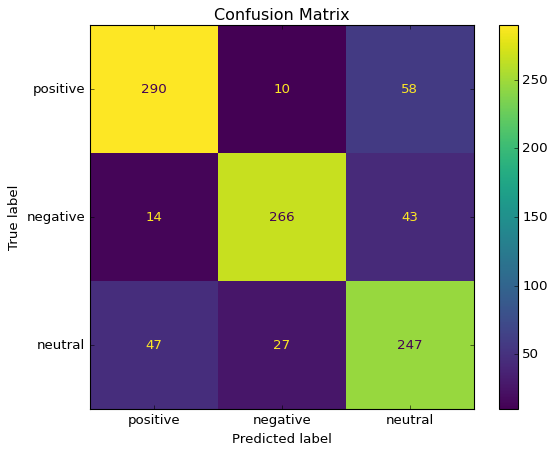

In [ ]:
target_names = ['positive', 'negative', 'neutral']
print(classification_report(labels, predictions, target_names=target_names, digits=4))

cm = confusion_matrix(labels, predictions)
_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()